In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")

ds_sst = xr.open_dataset("../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")['sst'][21:54,:,:,:]
#ds_FLNS = xr.open_dataset("../CESM_data/CESM1LE_FLNS_NAtl_19200101_20051201.nc")['FLNS'][21:54,0:89,:,:]
#ds_FSNS = xr.open_dataset("../CESM_data/CESM1LE_FSNS_NAtl_19200101_20051201.nc")['FSNS'][21:54,0:89,:,:]
#ds_LHFLX = xr.open_dataset("../CESM_data/CESM1LE_LHFLX_NAtl_19200101_20051201.nc")['LHFLX'][21:54,0:89,:,:]
#ds_NHFLX = xr.open_dataset("../CESM_data/CESM1LE_NHFLX_NAtl_19200101_20051201.nc")['NHFLX'][21:54,0:89,:,:]
#ds_SHFLX = xr.open_dataset("../CESM_data/CESM1LE_SHFLX_NAtl_19200101_20051201.nc")['SHFLX'][21:54,0:89,:,:]
ds_sss = xr.open_dataset("../CESM_data/CESM1LE_sss_NAtl_19200101_20051201.nc")['sss'][21:54,0:89,:,:]

In [3]:
def deseason(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]
    
    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

def deseason_amoc(arr):
    
    monthly_means = np.zeros((42,86,12))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind] = arr[:,it]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(arr.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it] = arr[:,it] - monthly_means[:,mo_ind]
    
    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

In [4]:
sst_deseasoned = deseason(ds_sst)
#FLNS_deseasoned = deseason(ds_FLNS)
#FSNS_deseasoned = deseason(ds_FSNS)
#LHFLX_deseasoned = deseason(ds_LHFLX)
#NHFLX_deseasoned = deseason(ds_NHFLX)
#SHFLX_deseasoned = deseason(ds_SHFLX)
sss_deseasoned = deseason(ds_sss)

<ipython-input-3-945e0c13ec7f>:11: RuntimeWarning: Mean of empty slice
  monthly_means = np.nanmean(monthly_means,axis=1)


In [5]:
amoc = ds_moc['MOC'][:,:,:,:,0:24].sum(dim='moc_comp').max(dim=('moc_z','lat_aux_grid')).values
amoc_deseasoned = deseason_amoc(amoc)

In [6]:
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)

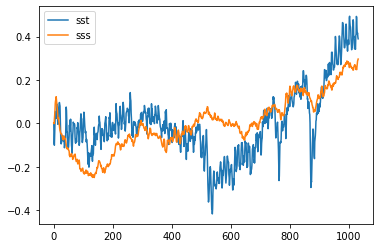

In [7]:
plt.plot(np.mean(sst_normed,axis=(0,2,3)))
plt.plot(np.mean(sss_normed,axis=(0,2,3)))

plt.legend(['sst','sss'])

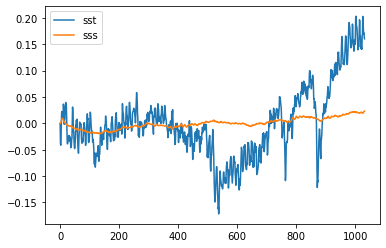

In [8]:
plt.plot(np.mean(sst_deseasoned,axis=(0,2,3)))
#plt.plot(np.mean(FLNS_deseasoned,axis=(0,2,3)))
#plt.plot(np.mean(FSNS_deseasoned,axis=(0,2,3)))
#plt.plot(np.mean(LHFLX_deseasoned,axis=(0,2,3)))
#plt.plot(np.mean(NHFLX_deseasoned,axis=(0,2,3)))
#plt.plot(np.mean(SHFLX_deseasoned,axis=(0,2,3)))
plt.plot(np.mean(sss_deseasoned,axis=(0,2,3)))

#plt.legend(['sst','FLNS','FSNS','LHFLX','NHFLX','SHFLX','sss'])
plt.legend(['sst','sss'])

In [9]:
#data_deseasoned = np.array( [sst_deseasoned,FLNS_deseasoned,
#                             FSNS_deseasoned,LHFLX_deseasoned,
#                             NHFLX_deseasoned,SHFLX_deseasoned,sss_deseasoned] )

data_normed = np.array( [sst_normed,sss_normed] )
channels = 2


In [10]:
lead = 12
tstep = 1032

y = np.mean(sst_normed[:,lead:,:,:],axis=(2,3)).reshape((tstep-lead)*42,1)   # predict SST
#y = amoc_deseasoned[:,lead:].reshape((tstep-lead)*42,1)                           # predict AMOC
X = data_normed[:,:,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*42,33,89)

In [11]:
shuffled_ind = np.arange(0,42*(tstep-lead),1)
np.random.seed(123)
np.random.shuffle(shuffled_ind)
X_shuffled =  np.transpose(X[:,shuffled_ind,:,:],(1,0,2,3)).astype(np.float32)
y_shuffled =  y[shuffled_ind].astype(np.float32)

In [12]:
percent_train = 0.8

X_train = torch.from_numpy( X_shuffled[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:,:] )
y_train = torch.from_numpy( y_shuffled[0:int(np.floor(percent_train*(tstep-lead)*42)),:] )

X_val = torch.from_numpy( X_shuffled[int(np.floor(percent_train*(tstep-lead)*42)):,:,:,:] )
y_val = torch.from_numpy( y_shuffled[int(np.floor(percent_train*(tstep-lead)*42)):,:] )

In [13]:
X_shuffled.shape

(42840, 2, 33, 89)

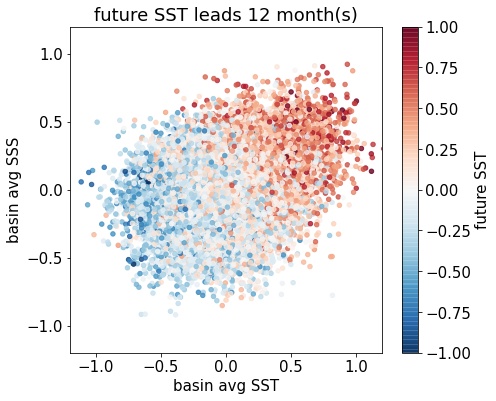

In [14]:
x1_pts = np.mean(X_shuffled[:,0,:,:],axis=(1,2))
x2_pts = np.mean(X_shuffled[:,1,:,:],axis=(1,2))
y_pts = y_shuffled

plt.figure(figsize=(7,6))
plt.rcParams.update({'font.size': 15})

sc = plt.scatter(x1_pts,x2_pts,c=y_pts,vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)
plt.colorbar(sc,label='future SST')
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.xlabel('basin avg SST')
plt.ylabel('basin avg SSS')
plt.title('future SST leads '+str(lead)+' month(s)')
plt.show()

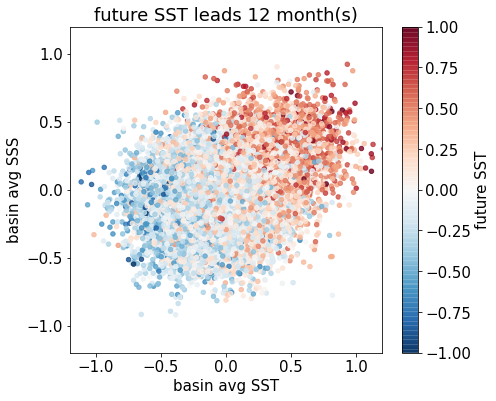

In [15]:
x1_pts = np.mean(X_train[:,0,:,:].numpy(),axis=(1,2))
x2_pts = np.mean(X_train[:,1,:,:].numpy(),axis=(1,2))
y_pts = y_train.numpy()

plt.figure(figsize=(7,6))
plt.rcParams.update({'font.size': 15})

sc = plt.scatter(x1_pts,x2_pts,c=y_pts,vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)
plt.colorbar(sc,label='future SST')
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.xlabel('basin avg SST')
plt.ylabel('basin avg SSS')
plt.title('future SST leads '+str(lead)+' month(s)')
plt.show()

In [16]:
model = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=5),
                      
          #nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
          #nn.ReLU(),
          #nn.MaxPool2d(kernel_size=3),
                      
          nn.Flatten(),
          nn.Linear(in_features=5*17*32,out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128,out_features=64),
          nn.ReLU(),
          
          nn.Dropout(p=0.5),
          nn.Linear(in_features=64,out_features=1))

opt = torch.optim.Adadelta(model.parameters())
#opt = torch.optim.SGD(model.parameters(),lr = 1e-4)
loss_fn = nn.MSELoss()

Test loss before training 0.16518697142601013


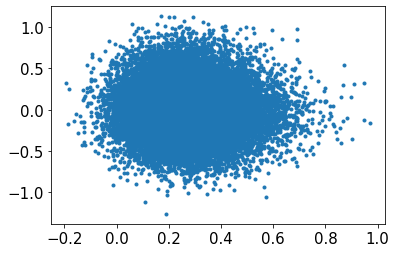

In [17]:
y_pred = model(X_train)
before_train = loss_fn(y_pred.squeeze(), y_train.squeeze())
print('Test loss before training' , before_train.item())
plt.plot(y_pred.detach().numpy(),y_train.numpy(),'.')

In [18]:
epoch = 20

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
    
    # Compute Loss
    loss = loss_fn(y_pred.squeeze(), y_train.squeeze())
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

  0%|          | 0/20 [00:02<?, ?it/s]


RuntimeError: [enforce fail at CPUAllocator.cpp:65] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 10813501440 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
plt.plot(epo_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
model.eval()
y_pred = model(X_train)
after_train = loss_fn(y_pred, y_train) 
print('Test loss after Training' , after_train.item())
plt.plot(y_pred.detach().numpy(),y_train.numpy(),'.')
plt.plot([-0.5,0.5],[-0.5,0.5])